In [6]:
# Imports

import csv
import pandas as pd
import itertools
import math
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import spacy
import string
import re
import nltk
import random
import praw
from google.colab import files
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import classification_report, plot_confusion_matrix

In [7]:
# Create dataframe using 2020PB source

# Import and normalize the json file 
df_2020pb = pd.read_json('https://raw.githubusercontent.com/2020PB/police-brutality/data_build/all-locations-v2.json')
df_2020pb = pd.json_normalize(df_2020pb['data'])
df_2020pb = df_2020pb.drop(columns=['edit_at'])

# Clean the urls
def cleanlinks(json):
    links_out = []
    for link in json:
        links_out.append(link['url'])
    return links_out


df_2020pb['links'] = df_2020pb['links'].apply(cleanlinks)
df_2020pb['date'] = pd.to_datetime(df_2020pb['date'],format='%Y-%m-%d')

# Create a list of all the tags
all_tags = df_2020pb['tags'].copy()
tags = set()
for taglist in all_tags:
  for tag in taglist:
    if tag not in tags:
      tags.add(tag)

df_2020pb.rename(columns={'name':'title'}, inplace=True)

df_2020pb.head()

,links,state,city,description,tags,geolocation,title,date,date_text,id
0,[https://www.youtube.com/watch?v=s7MM1VauRHo],Washington,Olympia,Footage shows a few individuals break off from...,"[arrest, less-lethal, projectile, protester, s...",,Police respond to broken windows with excessiv...,2020-05-31,May 31st,wa-olympia-1
1,[https://mobile.twitter.com/chadloder/status/1...,Washington,Seattle,Officer pins protester with his knee on his ne...,"[arrest, knee-on-neck, protester]",,Officer pins protester by pushing his knee int...,2020-05-30,May 30th,wa-seattle-1
2,[https://twitter.com/gunduzbaba1905/status/126...,Washington,Seattle,A couple of police officers are seen beating a...,"[beat, protester, punch]",,Police beat unarmed man on the ground,2020-05-31,May 31st,wa-seattle-2
3,[https://www.reddit.com/r/Bad_Cop_No_Donut/com...,Washington,Seattle,A police officer randomly and indiscriminately...,"[less-lethal, pepper-spray, protester]",,Police indiscriminately pepper spray peaceful ...,2020-05-31,May 31st,wa-seattle-3
4,[https://www.fox10phoenix.com/news/video-shows...,Washington,Seattle,Police pepper sprays a young child who is seen...,"[child, inhumane-treatment, less-lethal, peppe...",,Police pepper spray young child,2020-05-31,May 31st,wa-seattle-4


In [8]:
# Create new news.csv

!pip install praw

In [9]:
####  REDDIT CREDENTIALS HERE!

reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, password=PASSWORD, user_agent=USER_AGENT, username=USERNAME)

In [10]:
# Grabbing 1000 hottest posts on Reddit 

data = []

# Grab the data from the "news" subreddit
for submission in reddit.subreddit("news").hot(limit=1000):
  data.append([submission.id, submission.title, submission.score, submission.subreddit, submission.url, 
               submission.num_comments, submission.selftext, submission.created])

# Create and assign column names
col_names = ['id', 'title', 'score', 'subreddit', 'url', 
             'num_comments', 'text', 'created']
df_reddit = pd.DataFrame(data, columns=col_names)

df_reddit.head()

,id,title,score,subreddit,url,num_comments,text,created
0,j5m8qf,President Trump and US Government COVID-19 Meg...,1545,news,https://www.reddit.com/r/news/comments/j5m8qf/...,8978,**This thread is for discussing all things rel...,1.601943e+09
1,j6x28v,USPS employee arrested after allegedly dumping...,6522,news,https://abc7.com/usps-arrest-us-postal-service...,573,,1.602126e+09
2,j6s6aj,Federal appeals court rules Trump can't block ...,23155,news,https://www.cnn.com/2020/10/07/politics/trump-...,657,,1.602111e+09
3,j6r0jh,Family of Tyson employee in Iowa who died of C...,62876,news,https://www.desmoinesregister.com/story/money/...,1932,,1.602107e+09
4,j6qekn,Exclusive: OxyContin maker Purdue nears guilty...,5762,news,https://www.reuters.com/article/us-purdue-phar...,263,,1.602105e+09


In [11]:
# Combine dataframes for single source

df_combined = pd.concat([df_2020pb, df_reddit])

df_combined.head()

,links,state,city,description,tags,geolocation,title,date,date_text,id,score,subreddit,url,num_comments,text,created
0,[https://www.youtube.com/watch?v=s7MM1VauRHo],Washington,Olympia,Footage shows a few individuals break off from...,"[arrest, less-lethal, projectile, protester, s...",,Police respond to broken windows with excessiv...,2020-05-31,May 31st,wa-olympia-1,NaN,NaN,NaN,NaN,NaN,NaN
1,[https://mobile.twitter.com/chadloder/status/1...,Washington,Seattle,Officer pins protester with his knee on his ne...,"[arrest, knee-on-neck, protester]",,Officer pins protester by pushing his knee int...,2020-05-30,May 30th,wa-seattle-1,NaN,NaN,NaN,NaN,NaN,NaN
2,[https://twitter.com/gunduzbaba1905/status/126...,Washington,Seattle,A couple of police officers are seen beating a...,"[beat, protester, punch]",,Police beat unarmed man on the ground,2020-05-31,May 31st,wa-seattle-2,NaN,NaN,NaN,NaN,NaN,NaN
3,[https://www.reddit.com/r/Bad_Cop_No_Donut/com...,Washington,Seattle,A police officer randomly and indiscriminately...,"[less-lethal, pepper-spray, protester]",,Police indiscriminately pepper spray peaceful ...,2020-05-31,May 31st,wa-seattle-3,NaN,NaN,NaN,NaN,NaN,NaN
4,[https://www.fox10phoenix.com/news/video-shows...,Washington,Seattle,Police pepper sprays a young child who is seen...,"[child, inhumane-treatment, less-lethal, peppe...",,Police pepper spray young child,2020-05-31,May 31st,wa-seattle-4,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Extract id and title information 

df_titles = df_combined[['id', 'title']]

df_titles.head()

,id,title
0,wa-olympia-1,Police respond to broken windows with excessiv...
1,wa-seattle-1,Officer pins protester by pushing his knee int...
2,wa-seattle-2,Police beat unarmed man on the ground
3,wa-seattle-3,Police indiscriminately pepper spray peaceful ...
4,wa-seattle-4,Police pepper spray young child


In [13]:
# Create a csv from our combined dataframe

df_titles.to_csv('all_sources.csv', index=False) 


In [14]:
# Ensure that the csv is working by reading it back in and checking its head 

news = pd.read_csv('all_sources.csv')

news.head()

In [16]:
# Import not_brutality training csv

train_not_brutality = pd.read_csv('https://raw.githubusercontent.com/Lambda-School-Labs/Labs27-C-HRF-DS/main/notebooks/news.csv')

In [17]:
# Import is_brutality training csv


train_brutality = pd.read_csv('https://raw.githubusercontent.com/Lambda-School-Labs/Labs27-C-HRF-DS/main/notebooks/police_use_force.csv')

In [18]:
# Assign 0 to the police_brutality score in the not_brutality training csv and drop extraneous columns

train_not_brutality['police_brutality'] == 0

train_not_brutality = train_not_brutality.drop(['id', 'score','subreddit', 'url','num_comments','text','created'], axis=1)

train_not_brutality.head()

,title,police_brutality
0,Blizzard Employees Staged a Walkout After the ...,0
1,Kobe Bryant killed in helicopter crash in Cali...,0
2,Scientist Stephen Hawking has died aged 76,0
3,Jeffrey Epstein's autopsy more consistent with...,0
4,F.C.C. Announces Plan to Repeal Net Neutrality,0


In [19]:
# Ensure that the police brutality column consists of all 1s and rename name column

train_brutality['police_brutality'] == 1

train_brutality.rename(columns={'name':'title'}, inplace=True)

train_brutality.head()

,title,police_brutality
0,Compilation of incidents,1
1,Police shove a protesting woman down a set of ...,1
2,Police throw tear-gas at protesters on a bridge.,1
3,Police assault protesters,1
4,Police shoot non-violent protester in the head,1


In [20]:
# Combine training data

df = pd.concat([train_brutality, train_not_brutality])

df.head()

,title,police_brutality
0,Compilation of incidents,1
1,Police shove a protesting woman down a set of ...,1
2,Police throw tear-gas at protesters on a bridge.,1
3,Police assault protesters,1
4,Police shoot non-violent protester in the head,1


In [21]:
# Create tokenizer functions

nlp = spacy.load("en")


def tokenize(text):
    text = nlp(text)
    tokens = [token.lemma_ for token in text if (token.is_stop != True) and (token.is_punct != True) and (token.text != " ")]
    return tokens

def retoken(text):   
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    tokens = str(tokens)
    
    return tokens

In [22]:
# Apply tokenizer functions to our combined dataframe

df['tokens'] = df['title'].apply(tokenize)

df['tokens'] = df['title'].apply(retoken)

df.head()

,title,police_brutality,tokens
0,Compilation of incidents,1,"['compilation', 'of', 'incidents']"
1,Police shove a protesting woman down a set of ...,1,"['police', 'shove', 'a', 'protesting', 'woman'..."
2,Police throw tear-gas at protesters on a bridge.,1,"['police', 'throw', 'teargas', 'at', 'proteste..."
3,Police assault protesters,1,"['police', 'assault', 'protesters']"
4,Police shoot non-violent protester in the head,1,"['police', 'shoot', 'nonviolent', 'protester',..."


In [23]:
# Create vectorizer and fit and transform the tokens column 

vect = CountVectorizer()
vect.fit(df['tokens'])
dtm = vect.transform(df['tokens'])

In [24]:
# Create datafrane from features

dtm_df = pd.DataFrame(dtm.todense(), columns = vect.get_feature_names())

dtm_df.head()

,10,100,1000,10000,100000,100150,101,104,107,10acre,10bn,10th,10year,10yearold,11,11000,112,117,1191,11943,11th,11yearold,12,1200,120000,127700,12m,12th,12yearold,12yearolds,13,130,1300,13k,13th,14,14000,141,14yearold,15,...,wrongful,wrote,wtop,wuhan,wv,xbox,xi,xl,xxx,yang,yard,yards,yates,year,years,yearslong,yeezy,yelled,yelling,yellow,yells,yellsmerry,yiannopoulos,york,you,youd,young,younger,youporn,your,youre,youtube,zap,zealand,zeroes,zimbabwe,zip,zoo,zoom,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
# Separate dataframe into train and test datasets


X = df['title']
y = df['police_brutality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1590,)
(398,)
(1590,)
(398,)


In [26]:
# Build model pipeline using RFC

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=45,)),
])
pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

# Fit model 


param_distributions = {
   'classifier__max_depth': [1, 2, 3, 4, 5]}

search = RandomizedSearchCV(
   pipeline, 
   param_distributions=param_distributions, 
   n_iter=10, 
   cv=3, 
   scoring='accuracy', 
   verbose=10, 
   return_train_score=True, 
   n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.3s finished


In [28]:
# Check best parameters for further tuning

print('Best hyperparameters', search.best_params_)
print('Best Score', search.best_score_)

Best hyperparameters {'classifier__max_depth': 5}
Best Score 0.9075471698113208


In [29]:
# Check classification report 

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       187
           1       0.95      0.87      0.91       211

    accuracy                           0.91       398
   macro avg       0.91      0.91      0.91       398
weighted avg       0.91      0.91      0.91       398



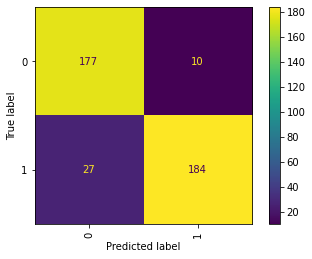

In [30]:
# Plot confusion matrix 

cm = plot_confusion_matrix(pipeline, X_test, y_test, values_format='.0f', xticks_rotation='vertical')
cm;

In [31]:
# Obtain ROC AUC score

from sklearn.metrics import roc_auc_score

y_pred_proba = pipeline.predict_proba(X_test)[:, -1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.9699039460678713


In [32]:
# Save and pickle the model for pickling

from pickle import dump

dump(pipeline, open('hrfc_rfmodel_v1.pkl', 'wb'))

In [33]:
# Load the model 

from pickle import load

loaded_model = load(open('hrfc_rfmodel_v1.pkl', 'rb'))

In [34]:
# Create a function to get predictions using the model 

def get_predictions(post, num_answers=2):
  """ takes a post and returns the top categories it fits in """

  # Get the predicted probabilities for each class
  preds = pd.Series(pipeline.predict_proba(post)[0])

  # Save each class to the Series index
  preds.index = pipeline.classes_

  # Sort to get the most likely classes
  preds = preds.sort_values(ascending=False)

  # Return the top num_answers results in dict format
  return preds[:num_answers].to_dict()

In [37]:
# Create a list with our titles to run model on 

titles_list = news['title'].tolist()

titles_list

['Police respond to broken windows with excessive force',
 'Officer pins protester by pushing his knee into his neck',
 'Police beat unarmed man on the ground',
 'Police indiscriminately pepper spray peaceful protesters',
 'Police pepper spray young child',
 'Police throw tear gas at peaceful protesters',
 'Police officer pulls protester to the ground unprovoked',
 'Law enforcement officer punches pinned protester',
 'Law enforcement officers throw flashbangs into peaceful crowd',
 'Police pepper spray crowd',
 'Police strike active news crew with tear gas',
 'Police injure sleeping homeless man with flashbang',
 'Officers deploy flashbangs and pepper spray peaceful protesters',
 'Protester targeted days after protest',
 'Officer chokes and places knee on neck of woman',
 'Police kettle protesters to force them to disperse through tear-gas',
 "Police pepper spray protesters who can't move back",
 'Woman hit with police projectile resumes breathing after CPR, delivered to hospital',
 'D

In [38]:
# Run model and save to list of predictions

predictions = []

for title in titles_list: 
     predictions.append(get_predictions([title]))

In [39]:
# Save predictions into a column on the news dataframe. Check results

news['prediction'] = predictions

news.head(10)

,id,title,prediction
0,wa-olympia-1,Police respond to broken windows with excessiv...,"{1: 0.5283035496148865, 0: 0.47169645038511343}"
1,wa-seattle-1,Officer pins protester by pushing his knee int...,"{1: 0.5430818095909811, 0: 0.4569181904090189}"
2,wa-seattle-2,Police beat unarmed man on the ground,"{1: 0.5954887717485916, 0: 0.4045112282514083}"
3,wa-seattle-3,Police indiscriminately pepper spray peaceful ...,"{1: 0.6111528326363925, 0: 0.3888471673636074}"
4,wa-seattle-4,Police pepper spray young child,"{1: 0.5353496951891153, 0: 0.4646503048108846}"
5,wa-seattle-8,Police throw tear gas at peaceful protesters,"{1: 0.6821996736846465, 0: 0.3178003263153536}"
6,wa-seattle-6,Police officer pulls protester to the ground u...,"{1: 0.5274543670667825, 0: 0.4725456329332175}"
7,wa-seattle-12,Law enforcement officer punches pinned protester,"{1: 0.5658955721982424, 0: 0.43410442780175756}"
8,wa-seattle-7,Law enforcement officers throw flashbangs into...,"{1: 0.560186804437689, 0: 0.439813195562311}"
9,wa-seattle-9,Police pepper spray crowd,"{1: 0.5353496951891153, 0: 0.4646503048108846}"
